# A simple implementation of ESNs

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Data visualization

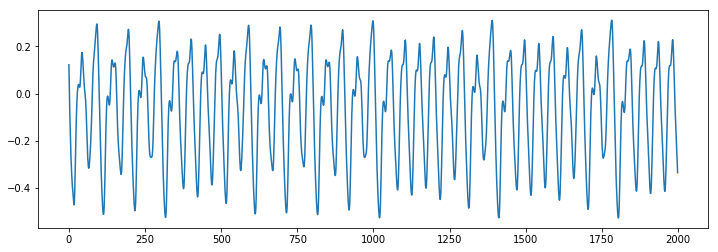

In [2]:
data = np.load('mackey_glass_t17.npy') #  http://minds.jacobs-university.de/mantas/code

mylen = 2000
plt.figure(figsize=(12, 4))
plt.plot(np.arange(mylen), data[:mylen])
plt.savefig('data.pdf')

In [3]:
# data.shape = [1, T]
data = np.reshape(data, (1, data.shape[0]))
print(data.shape)

(1, 10000)


## Initialize ESNs

0.09938386099778017


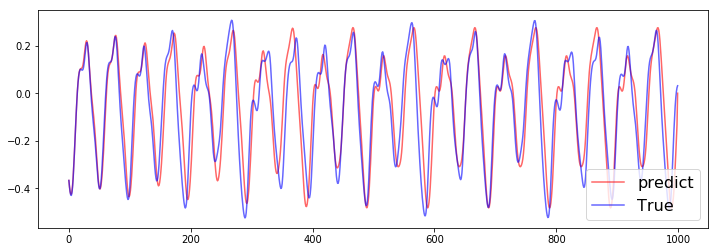

In [12]:
# This simple implementation only works on scalar input/output
np.random.seed(2050)
N = 1000 # reservoir size
rho = 1.36 # spetral radius
sparsity = 3/N
N_t = 2000 # training steps
N_tp = 1000 # prediction steps
d = 200 # discard first d steps
eta = 1e-4

# Initialization
W_IR = np.random.rand(N, 1) * 2 - 1 # [-1, 1] uniform 
W_res = np.random.rand(N, N)
W_res[W_res > sparsity] = 0
W_res = W_res / np.max(np.abs(np.linalg.eigvals(W_res))) * rho

# Training
r = np.zeros((N, N_t+1))
u = data[:, :N_t] # Training data size=(1, N_t)
for t in range(N_t):
    r[:, t+1] = np.tanh(W_res @ r[:, t] + W_IR @ u[:, t])
    
# disgard first d steps
rp = r[:, d+1:]
v = data[:, d+1:N_t+1] # target
W_RO = v @ rp.T @ np.linalg.pinv(rp @ rp.T + eta * np.identity(N))

# prediction
u_pred = np.zeros((1, N_tp))
r_pred = np.zeros((N, N_tp))
r_pred[:, 0] = rp[:, -1] # warm start
for step in range(N_tp-1):
    u_pred[:, step] = W_RO @ r_pred[:, step]
    r_pred[:, step+1] = np.tanh(W_res @ r_pred[:, step] + W_IR @ u_pred[:, step])

error = np.sqrt(np.mean((u_pred - data[:, N_t:N_t+N_tp])**2))
print(error)
plt.figure(figsize=(12, 4))
plt.plot(u_pred.T, 'r', label='predict', alpha=0.6)
plt.plot(data[:, N_t:N_t+N_tp].T, 'b', label='True', alpha=0.6)
# plt.xticks([2001, 3000])
plt.legend(fontsize=16)
plt.savefig('my_reproduce.pdf')

## Search hyperparameters

In [5]:
def myesns(rho):
    np.random.seed(2050)
    N = 1000 # reservoir size
#     rho = 1.3 # spetral radius
    sparsity = 3/N
    N_t = 2000 # training steps
    N_tp = 1000 # prediction steps
    d = 200 # discard first d steps
    eta = 1e-4

    # Initialization
    W_IR = np.random.rand(N, 1) * 2 - 1 # [-1, 1] uniform 
    W_res = np.random.rand(N, N)
    W_res[W_res > sparsity] = 0
    W_res = W_res / np.max(np.abs(np.linalg.eigvals(W_res))) * rho

    # Training
    r = np.zeros((N, N_t+1))
    u = data[:, :N_t] # Training data size=(1, N_t)
    for t in range(N_t):
        r[:, t+1] = np.tanh(W_res @ r[:, t] + W_IR @ u[:, t])

    # disgard first d steps
    rp = r[:, d+1:]
    v = data[:, d+1:N_t+1] # target
    W_RO = v @ rp.T @ np.linalg.pinv(rp @ rp.T + eta * np.identity(N))

    # prediction
    u_pred = np.zeros((1, N_tp))
    r_pred = np.zeros((N, N_tp))
    r_pred[:, 0] = rp[:, -1] # warm start
    for step in range(N_tp-1):
        u_pred[:, step] = W_RO @ r_pred[:, step]
        r_pred[:, step+1] = np.tanh(W_res @ r_pred[:, step] + W_IR @ u_pred[:, step])

    error = np.sqrt(np.mean((u_pred - data[:, N_t:N_t+N_tp])**2))
    print(error)
    return error
#     plt.figure(figsize=(12, 4))
#     plt.plot(u_pred.T, label='predict')
#     plt.plot(data[:, N_t:N_t+N_tp].T, label='True')
#     plt.legend(fontsize=16)

In [6]:
rho_set = np.arange(1.3, 1.4, 0.01)
rho_set_size = len(rho_set)
loss = []

for i, rho in enumerate(rho_set):
    loss.append(myesns(rho))

0.2917877019018379
0.2821606153560273
0.26716913290785976
0.23953903294795792
0.19946020064283235
0.14757661974823616
0.09938386099778017
0.10525823648251714
0.1486505755582024
0.18609291854643398


Text(0, 0.5, 'RMSE')

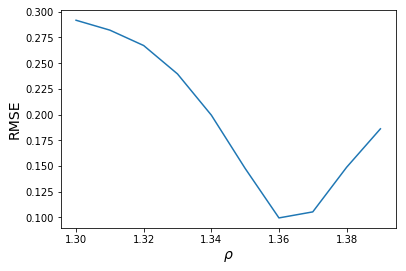

In [7]:
plt.plot(rho_set, loss)
plt.xlabel(r'$\rho$', fontsize=14)
plt.ylabel('RMSE', fontsize=14)
# plt.xticks(rho_set)
# plt.savefig('my_reproduce_2.pdf')